## Problem Statement

The objective of this project is to build a predictive model that estimates the probability that a building will have at least one insurance claim during its insured period.

The target variable `Claim` is defined as:
- 1: Building has at least one claim
- 0: Building has no claim

The prediction is based solely on building characteristics provided in the dataset.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # Import the imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix, 
    classification_report, 
    log_loss
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

sns.set(style="whitegrid")

In [38]:
df = pd.read_csv("Train_data.csv")
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


## Data Overview
We inspect the dataset structure, data types, and missing values.


In [39]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

## Data Cleaning and Feature Engineering

Key steps:
- Drop Customer Id (identifier)
- Fix malformed NumberOfWindows
- Create Building Age feature


In [40]:
df = df.drop(columns=["Customer Id"])

# 1. Clean up extra whitespace around the values
df["NumberOfWindows"] = df["NumberOfWindows"].astype(str).str.strip()

# 2. Replace any remaining solitary periods (now free of whitespace) with NaN
df["NumberOfWindows"] = df["NumberOfWindows"].replace(".", np.nan)

# 3. Use pd.to_numeric with errors='coerce' for robust conversion
#    This converts any remaining unparseable values into NaN automatically.
df["NumberOfWindows"] = pd.to_numeric(df["NumberOfWindows"], errors='coerce')

# df["NumberOfWindows"] = df["NumberOfWindows"].replace(".", np.nan)
df["NumberOfWindows"] = df["NumberOfWindows"].astype(float)

df["Building_Age"] = df["YearOfObservation"] - df["Date_of_Occupancy"]


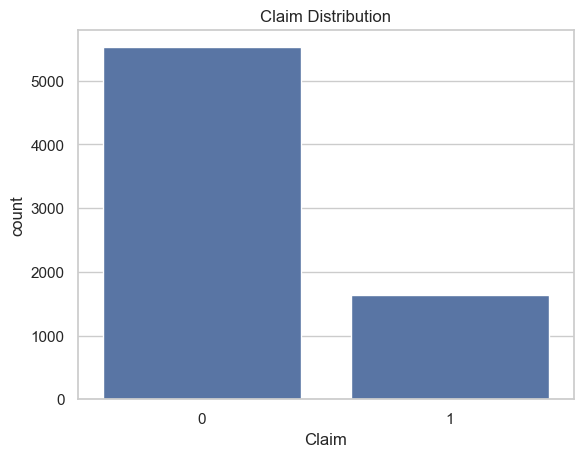

In [41]:
sns.countplot(x="Claim", data=df)
plt.title("Claim Distribution")
plt.show()


Insight:
The dataset is imbalanced, with significantly fewer claim events. This justifies the use of ROC-AUC and Log Loss instead of accuracy.


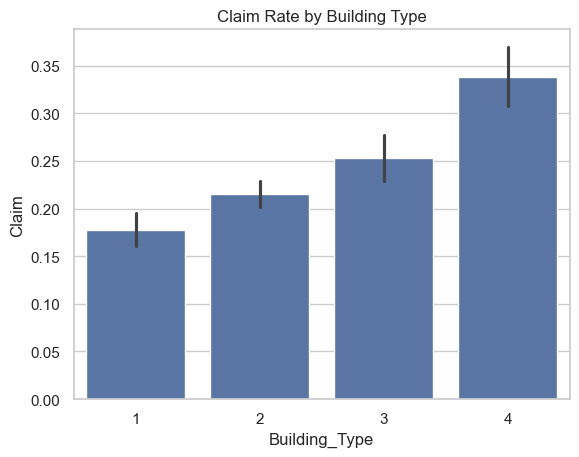

In [42]:
sns.barplot(x="Building_Type", y="Claim", data=df)
plt.title("Claim Rate by Building Type")
plt.show()


Insight:
Certain building types show higher claim frequency, indicating structural risk differences.


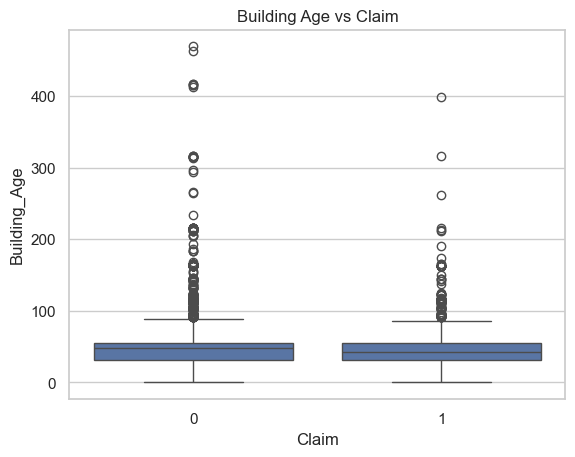

In [43]:
sns.boxplot(x="Claim", y="Building_Age", data=df)
plt.title("Building Age vs Claim")
plt.show()


Insight:
Older buildings tend to exhibit higher claim probability, likely due to aging infrastructure.


We apply separate preprocessing pipelines for numerical and categorical features to ensure reproducibility and prevent data leakage.


In [57]:
X = df.drop("Claim", axis=1)
y = df["Claim"]

cat_features = X.select_dtypes(include="object").columns
num_features = X.select_dtypes(exclude="object").columns

# 1. Create a pipeline for numeric features: Impute NaNs, then Scale
numeric_transformer = Pipeline(steps=[
    # Fill missing numeric values with the median of the column
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# 2. Create a pipeline for categorical features: Impute NaNs, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    # Fill missing categorical values with the constant 'missing'
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# 3. Combine these pipelines in the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [58]:
log_model = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)
log_probs = log_model.predict_proba(X_test)[:, 1]


In [59]:
rf_model = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]


In [60]:
gb_model = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

gb_model.fit(X_train, y_train)
gb_probs = gb_model.predict_proba(X_test)[:, 1]


In [61]:
models = {
    "Logistic Regression": log_probs,
    "Random Forest": rf_probs,
    "Gradient Boosting": gb_probs
}

results = []

for name, probs in models.items():
    results.append({
        "Model": name,
        "ROC_AUC": roc_auc_score(y_test, probs),
        "LogLoss": log_loss(y_test, probs)
    })

results_df = pd.DataFrame(results)
results_df


,Model,ROC_AUC,LogLoss
0,Logistic Regression,0.683272,0.508199
1,Random Forest,0.657153,0.543179
2,Gradient Boosting,0.682632,0.497012


## Model Selection and Conclusion

Logistic Regression achieved the highest ROC-AUC score (0.683),
indicating the strongest overall ability to discriminate between
buildings with and without insurance claims.

Gradient Boosting achieved the lowest Log Loss (0.497), suggesting
better probability calibration and more reliable risk estimates.

Given the marginal difference in ROC-AUC and the importance of model
interpretability in insurance applications, Logistic Regression was
selected as the final model. However, Gradient Boosting remains a strong
alternative where probability precision is prioritized.


This project demonstrated a complete end-to-end machine learning pipeline for insurance claim prediction.

Key highlights:
- Thorough data cleaning and feature engineering
- Insight-driven EDA
- Robust preprocessing pipelines
- Multiple model experimentation
- Business-relevant evaluation metrics

The resulting model can support insurers in proactive risk assessment and pricing strategies.
